In [1]:
import os
os.chdir("..")

In [2]:
import pickle

import numpy as np
np.random.seed(1234)

from tqdm import tqdm
from functools import partial

# Plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from hips.plotting.colormaps import gradient_cmap
from hips.plotting.layout import create_axis_at_location
import seaborn as sns
sns.set_style("white")
sns.set_context("paper")
color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]
colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

from zimmer.io import load_kato_data
import zimmer.plotting as zplt

%matplotlib inline

In [3]:
results_dir = os.path.join("results", "kato", "2018-02-26-hlds", "run001")
assert os.path.exists(results_dir)
fig_dir = os.path.join(results_dir, "figures")
mov_dir = os.path.join(results_dir, "movies")

In [4]:
# Load the continuous states found with the LDS
ys, ms, z_trues, z_true_key, neuron_names = load_kato_data(include_unnamed=False)

with open(os.path.join(results_dir, "lds_data.pkl"), "rb") as f:
    lds_results = pickle.load(f)
    
# Extract test and train results
xtrains, xtests, = lds_results["xtrains"], lds_results["xtests"]
ytrains, ytests = lds_results["ytrains"], lds_results["ytests"]
z_true_trains, z_true_tests = lds_results["z_true_trains"], lds_results["z_true_tests"]
mtrains, mtests, = lds_results["mtrains"], lds_results["mtests"]
n_trains = np.array([mtr.sum() for mtr in mtrains])
n_tests = np.array([mte.sum() for mte in mtests])

# concatenate
xs = [np.vstack((xtr, xte)) for xtr, xte in zip(xtrains, xtests)]

# Load other results
best_model = lds_results["best_model"]
neuron_perm = lds_results["neuron_perm"]
neuron_clusters = lds_results["neuron_clusters"]
N_clusters = lds_results["N_clusters"]
C = lds_results["C"]
dim_perm = lds_results["perm"]
        
D_latent = best_model.D_latent
D_obs = ytrains[0].shape[1]
N_worms = len(xtrains)

print("Loading results with {} worms and {} neurons".format(D_obs, N_worms))

Only including named neurons.
59 neurons across all 5 worms
Loading results with 59 worms and 5 neurons


In [5]:
def _plot_likelihoods(D_latents, final_lls, hlls, best_index,
                     color, name, axs=None):

    # Plot results of searching over models
    if axs is None:
        plt.figure(figsize=(6,3))
        ax1 = plt.subplot(121)
        ax2 = plt.subplot(122)
    else:
        ax1, ax2 = axs
    
    ax1.plot(D_latents, final_lls / n_trains.sum(),
             '-', markersize=6, color=color)
    for index in range(len(D_latents)):
        if index != best_index:
            ax1.plot(D_latents[index], final_lls[index] / n_trains.sum(),
                     'o', markersize=6, color=color)

    ax1.plot(D_latents[best_index], final_lls[best_index] / n_trains.sum(),
             '*', markersize=10, color=color)
    ax1.set_xlabel("Latent Dimension")
    ax1.set_ylabel("Train Log Likelihood")

    ax2.plot(D_latents, hlls / n_tests.sum(),
             '-', markersize=6, color=color, label=name)

    for index in range(len(D_latents)):
        if index != best_index:
            ax2.plot(D_latents[index], hlls[index] /  n_tests.sum(),
                     'o', markersize=6, color=color)

    ax2.plot(D_latents[best_index], hlls[best_index] / n_tests.sum(),
             '*', markersize=10, color=color)
    ax2.set_xlabel("Latent Dimension")
    ax2.set_ylabel("Test Log Likelihood")

    return ax1, ax2


def plot_likelihoods(results):
    axs = None
    for index, key in enumerate(["hier", "no_hier"]):
        best_model, best_index, models, llss, final_lls, hlls = results[key]
        D_latents = [model.D_latent for model in models]
        axs = _plot_likelihoods(D_latents, final_lls, hlls, best_index,
                                name=key, color=colors[index], axs=axs)
    plt.tight_layout()
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(fig_dir, "dimensionality.pdf"))

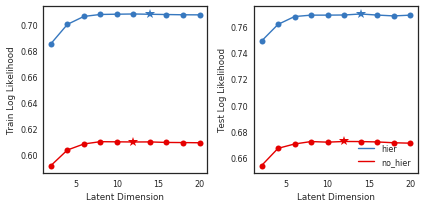

In [6]:
plot_likelihoods(lds_results["fit_results"])

In [7]:
# from sklearn.decomposition import PCA
# for i in range(N_worms):
#     plot_3d_continuous_states(xtrains[i], np.zeros(xtrains[i].shape[0], dtype=int), colors,
#                               figsize=(1.2, 1.2),
#                               # title="LDS Worm {} States (Zimmer Lables)".format(i + 1),
#                               results_dir=fig_dir,
#                               filename="xtr_{}.pdf".format(i + 1),
#                               # lim=1.5,
#                               lw=1, alpha=0.85)
#     pca = PCA(3)
#     yi = ytrains[i][:, mtrains[i][0]]
#     assert False
#     x = pca.fit_transform(yi)

#     model, _, _ = _fit_lds(3, datas=[ytrains[i]], masks=[mtrains[i]], compute_hll=False)
#     x = model.states_list[0].gaussian_states
#     make_states_3d_movie(np.zeros(1000, dtype=int),
#                          x[:1000],
#                          title=None,
#                          lim=None,
#                          inds=(0, 1, 2),
#                          colors=colors,
#                          figsize=(1.2, 1.2),
#                          filepath=os.path.join(fig_dir, "x_pca_{}.mp4".format(i+1)),
#                          lw=0.25)

plt.close("all")


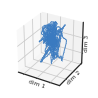

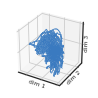

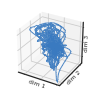

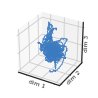

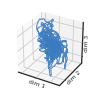

In [8]:
for i in range(N_worms):
    zplt.plot_3d_continuous_states(
        xtrains[i], np.zeros(xtrains[i].shape[0], dtype=int), colors,
        figsize=(1.2, 1.2),
        # title="LDS Worm {} States (Zimmer Lables)".format(i + 1),
        results_dir=fig_dir,
        filename="xtr_{}.pdf".format(i + 1),
        # lim=1.5,
        lw=1, alpha=0.85)

100%|██████████| 360/360 [00:05<00:00, 61.20it/s]


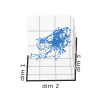

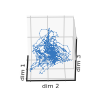

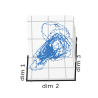

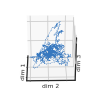

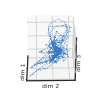

In [9]:
for i in range(N_worms):
    zplt.make_states_3d_movie(
        np.zeros(1000, dtype=int),
        xtrains[i][:1000],
        title=None,
        lim=None,
        inds=(0, 1, 2),
        colors=colors,
        figsize=(1.2, 1.2),
        filepath=os.path.join(mov_dir, "xtr_{}.mp4".format(i+1)),
        lw=0.25)

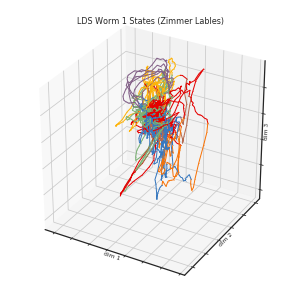

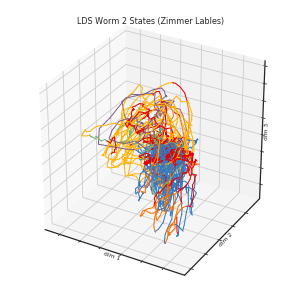

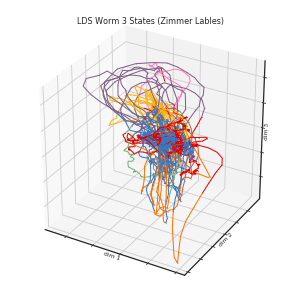

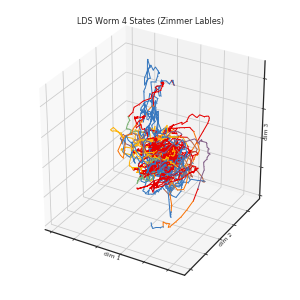

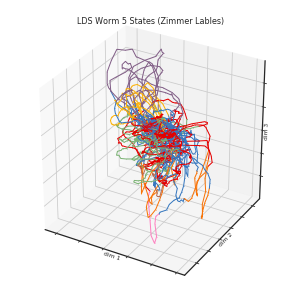

In [10]:
for i in range(N_worms):
    zplt.plot_3d_continuous_states(xtrains[i], z_true_trains[i], colors,
                              figsize=(4, 4),
                              title="LDS Worm {} States (Zimmer Lables)".format(i + 1),
                              results_dir=fig_dir,
                              filename="xtr_zimmer_{}.pdf".format(i + 1),
                              # lim=1.5,
                              lw=1)

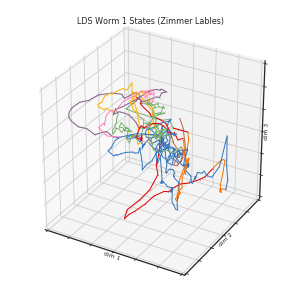

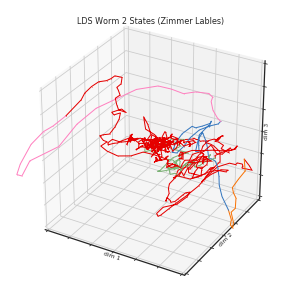

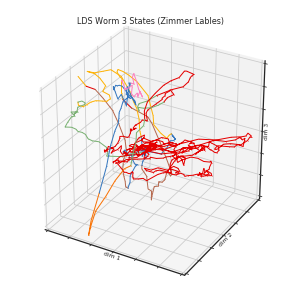

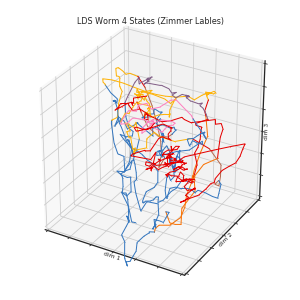

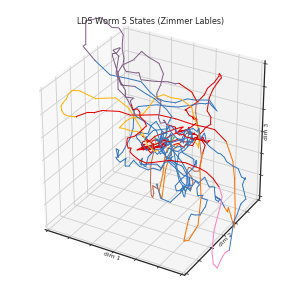

In [11]:
for i in range(N_worms):
    zplt.plot_3d_continuous_states(xtests[i], z_true_tests[i], colors,
                              figsize=(4, 4),
                              title="LDS Worm {} States (Zimmer Lables)".format(i + 1),
                              results_dir=fig_dir,
                              filename="xte_zimmer_{}.pdf".format(i + 1),
                              lim=1.5,
                              lw=1)

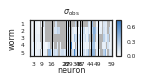

In [12]:
# Look at the observation variance across worms
sigma_obs = best_model.emission_distn.sigmasq_flat.copy()
sigma_obs_mask = np.array([np.any(~m, axis=0) for m in ms])
sigma_obs[sigma_obs_mask] = np.nan

cmap = gradient_cmap([np.ones(3), colors[0]])
cmap.set_bad(0.7 * np.ones(3))

fig = plt.figure(figsize=(1.9, 1.0))
# ax = fig.add_subplot(111)
ax = create_axis_at_location(fig, 0.4, 0.3, 1.15, .5)
im = ax.imshow(np.sqrt(sigma_obs)[:,neuron_perm], vmin=0, aspect="auto", cmap=cmap)


# Plot lines at each cluster
cluster_sizes = np.bincount(neuron_clusters, minlength=N_clusters)
cluster_offsets = np.cumsum(cluster_sizes) - 1


for o in cluster_offsets[:-1]:
    ax.plot([o+.5, o+.5], [-.5, N_worms-.5], '-', lw=1, color='k')

ax.set_xlim(-0.5, D_obs - 0.5)
plt.xticks(cluster_offsets, cluster_offsets + 1, fontsize=6)
ax.set_xlabel("neuron", fontsize=8, labelpad=-1)

ax.set_ylim(N_worms -0.5, -0.5)
ax.set_yticks(np.arange(N_worms))
ax.set_yticklabels(np.arange(N_worms) + 1, fontsize=6)
ax.set_ylabel("worm", fontsize=8)

ax.set_title("$\sigma_{\mathsf{obs}}$", fontsize=8)

cax = create_axis_at_location(fig, 1.6, 0.3, .075, .5)
cbar = plt.colorbar(im, cax=cax, ticks=[0, 0.3, 0.6])
cbar.ax.tick_params(labelsize=6)
# plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(fig_dir, "observation_variance.pdf"))

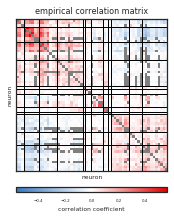

In [13]:
# Plot the correlation matrix

def comput_xcorr(ys, masks):
    N = D_obs
    xcorr = np.nan * np.ones((N, N))
    for n1 in range(N):
        for n2 in range(n1+1, N):
            valid = [(np.all(ms[i][:,n1]) and np.all(ms[i][:,n2])) for i in range(N_worms)]
            if np.any(valid):
                y1s = np.concatenate([ys[i][:, n1] for i in range(N_worms) if valid[i]])
                y2s = np.concatenate([ys[i][:, n2] for i in range(N_worms) if valid[i]])
                xcorr[n1, n2] = np.corrcoef(y1s, y2s)[0, 1]
                xcorr[n2, n1] = xcorr[n1, n2]
    return xcorr

xcorr = comput_xcorr([np.vstack((ytr, yte)) for ytr, yte in zip(ytrains, ytests)],
                     [np.vstack((mtr, mte)) for mtr, mte in zip(mtrains, mtests)])

fig = plt.figure(figsize=(2.5, 3.0))
ax = create_axis_at_location(fig, 0.3, 0.6, 2.1, 2.1)

cmap = gradient_cmap([colors[0], np.ones(3), colors[1]])
cmap.set_bad(0.5 * np.ones(3))
np.fill_diagonal(xcorr, np.nan)
lim = max(abs(np.nanmax(xcorr)), abs(np.nanmin(xcorr)))
im = ax.imshow(xcorr[np.ix_(neuron_perm, neuron_perm)], cmap=cmap, vmin=-lim, vmax=lim)

for o in cluster_offsets[:-1]:
    ax.plot([o + .5, o + .5], [-0.5, D_obs + 0.5], '-', lw=1, color='k')
    ax.plot([-.5, D_obs + 0.5], [o + .5, o + .5], '-', lw=1, color='k')
plt.xlim(-0.5, D_obs - 0.5)
plt.ylim(D_obs - 0.5, -0.5)
plt.xlabel("neuron", fontsize=6)
plt.ylabel("neuron", fontsize=6)
# plt.xticks(np.arange(D_obs), neuron_names[neuron_perm], rotation=90, fontsize=3)
# plt.yticks(np.arange(D_obs), neuron_names[neuron_perm], fontsize=3)
plt.xticks([])
plt.yticks([])
plt.title("empirical correlation matrix", fontsize=8)

cax = create_axis_at_location(fig, 0.3, 0.3, 2.1, 0.075)
cbar = plt.colorbar(mappable=im, cax=cax, orientation="horizontal")
cbar.ax.tick_params(labelsize=4)
cbar.ax.set_xlabel("correlation coefficient", fontsize=6)

plt.savefig(os.path.join(fig_dir, "permuted_correlation.pdf"))
plt.savefig(os.path.join(fig_dir, "permuted_correlation.png"), dpi=300)


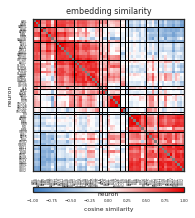

In [14]:
S_true = C.dot(C.T)
S_true /= np.linalg.norm(C, axis=1)[:, None]
S_true /= np.linalg.norm(C, axis=1)[None, :]

# Plot the similarity matrix
fig = plt.figure(figsize=(2.5, 3.0))
ax = create_axis_at_location(fig, 0.3, 0.6, 2.1, 2.1)

cmap = gradient_cmap([colors[0], np.ones(3), colors[1]])
cmap.set_bad(0.5 * np.ones(3))
np.fill_diagonal(S_true, np.nan)
im = ax.imshow(S_true[np.ix_(neuron_perm, neuron_perm)], cmap=cmap, vmin=-1, vmax=1)

for o in cluster_offsets[:-1]:
    ax.plot([o + .5, o + .5], [-0.5, D_obs + 0.5], '-', lw=1, color='k')
    ax.plot([-.5, D_obs + 0.5], [o + .5, o + .5], '-', lw=1, color='k')
plt.xlim(-0.5, D_obs - 0.5)
plt.ylim(D_obs - 0.5, -0.5)
plt.xlabel("neuron", fontsize=6)
plt.ylabel("neuron", fontsize=6)
plt.xticks(np.arange(D_obs), neuron_names[neuron_perm], rotation=90, fontsize=3)
plt.yticks(np.arange(D_obs), neuron_names[neuron_perm], fontsize=3)
# plt.xticks([])
# plt.yticks([])
plt.title("embedding similarity", fontsize=8)

cax = create_axis_at_location(fig, 0.3, 0.3, 2.1, 0.075)
cbar = plt.colorbar(mappable=im, cax=cax, orientation="horizontal")
cbar.ax.tick_params(labelsize=4)
cbar.ax.set_xlabel("cosine similarity", fontsize=6)

plt.savefig(os.path.join(fig_dir, "permuted_similarity.pdf"))
plt.savefig(os.path.join(fig_dir, "permuted_similarity.png"), dpi=300)

In [15]:
# fig = plt.figure(figsize=(1, 1))
# ax = fig.add_subplot(111, projection="3d")
# for cluster in range(N_clusters):
#     for i in np.where(neuron_clusters == cluster)[0]:
#         ci = C[i]
#         ci /= np.linalg.norm(ci)
#         ax.plot([0, ci[0]], [0, ci[1]], [0, ci[2]],
#                  '-k', lw=.5)
#         ax.plot([ci[0]], [ci[1]], [ci[2]],
#                 'ok', markersize=2)
#         # ax.text(1.1 * ci[0], 1.1 * ci[1], 1.1 * ci[2], neuron_names[i], fontsize=6)
#
#     ax.set_xlabel("dim 1", labelpad=-17, fontsize=6)
#     ax.set_ylabel("dim 2", labelpad=-17, fontsize=6)
#     ax.set_zlabel("dim 3", labelpad=-17, fontsize=6)
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])
#     ax.set_zticklabels([])
#     ax.set_xlim(-.75, .75)
#     ax.set_ylim(-.75, .75)
#     ax.set_zlim(-.75, .75)
#
# plt.tight_layout(pad=0.05)
# plt.savefig(os.path.join(fig_dir, "embedding.pdf"))

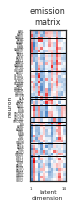

In [16]:
fig = plt.figure(figsize=(1., 3.0))
ax = create_axis_at_location(fig, 0.4, 0.6, 0.5, 2.1)
C_norm = C / np.linalg.norm(C, axis=1, keepdims=True)
lim = abs(C_norm).max()
cmap = gradient_cmap([colors[0], np.ones(3), colors[1]])
ax.imshow(C_norm[neuron_perm][:,:-1], aspect="auto", vmin=-lim, vmax=lim, cmap=cmap)

for o in cluster_offsets[:-1]:
    ax.plot([-.5, D_latent-.5], [o+.5, o+.5], '-', lw=1, color='k')

ax.set_ylabel("neuron", labelpad=1, fontsize=6)
plt.yticks(np.arange(D_obs), neuron_names[neuron_perm], fontsize=3)
ax.set_xlabel("latent\ndimension", labelpad=-1, fontsize=6)
ax.set_xticks([0, D_latent-1])
ax.set_xticklabels([1, D_latent], fontsize=4)
ax.set_title("emission\nmatrix", fontsize=8)

plt.savefig(os.path.join(fig_dir, "C.pdf"))

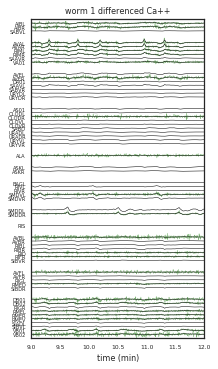

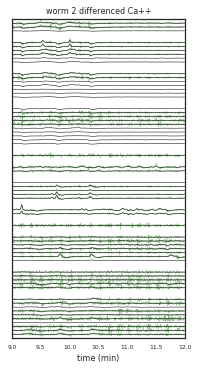

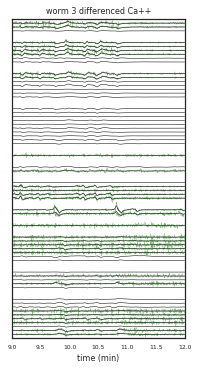

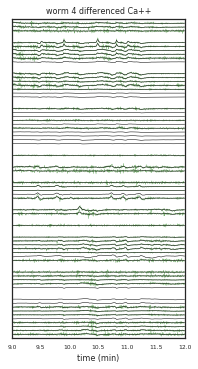

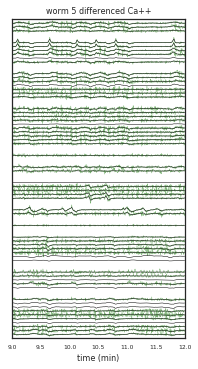

In [17]:
all_ys = np.vstack(ys)
all_ms = np.vstack(ms)
all_ys[~all_ms] = np.nan
scales = np.nanstd(all_ys, axis=0)

for i in range(N_worms):
    ysm = best_model.smooth(ys[i], mask=ms[i],
                      inputs=np.ones((ys[i].shape[0], 1)),
                      group=i)

    y = ys[i].copy()
    spc = 5

    n_start = 9 * 60 * 3
    n_frames = 3 * 60 * 3 + 1
    t = n_start / 180.0 + np.arange(n_frames) / 180.0

    fig = plt.figure(figsize=(3, 5))
    left = .5 if i == 0 else .1
    ax = create_axis_at_location(fig, left, .4, 2.4, 4.43)
    offset = 0
    ticks = []
    for c in range(N_clusters):
        for n in neuron_perm:
            if neuron_clusters[n] != c:
                continue

            if ms[i][0, n]:
                plt.plot(t, -y[n_start:n_start+n_frames, n] / scales[n] + spc * offset, '-', color=colors[3], lw=.5)
            else:
                # plt.plot(t, np.zeros_like(t) + spc * offset, ':', color='k', lw=.5)
                pass
            plt.plot(t, -ysm[n_start:n_start+n_frames, n] / scales[n] + spc * offset, '-', color='k', lw=.5)

            ticks.append(offset * spc)
            offset += 1

        # Add an extra space between clusters
        offset += 2

    # Remove last space
    offset -= 2

    if i == 0:
        plt.yticks(ticks, neuron_names[neuron_perm], fontsize=5)
    else:
        plt.yticks([])

    plt.ylim(offset * spc, -spc)
    plt.ylim(offset * spc, -spc)
    plt.xlim(t[0], t[-1])
    plt.xticks(fontsize=6)
    plt.xlabel("time (min)", fontsize=8)

    plt.title("worm {} differenced Ca++".format(i+1), fontsize=8)

    plt.savefig(os.path.join(fig_dir, "y_{}.pdf".format(i)))

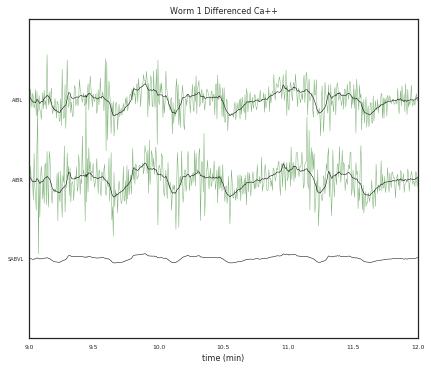

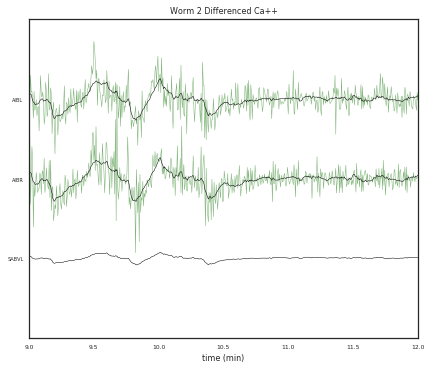

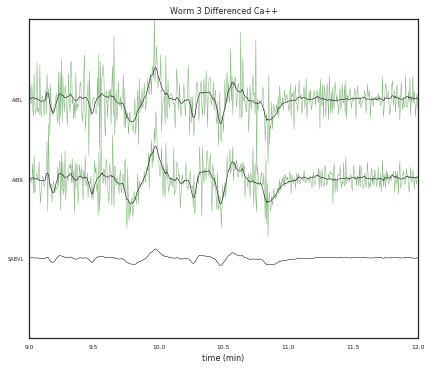

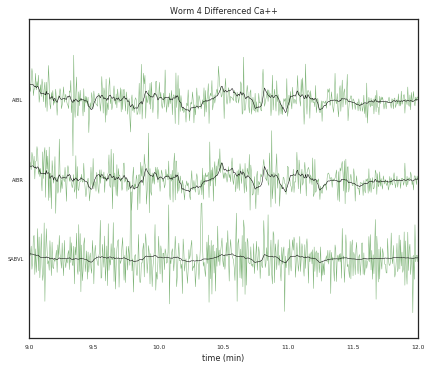

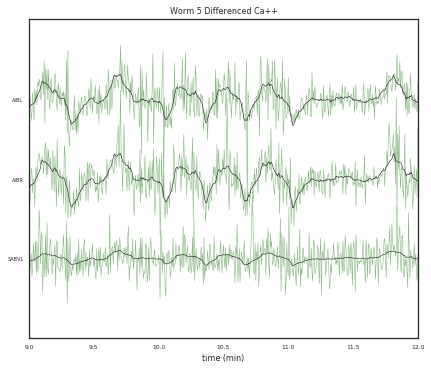

In [18]:
all_ys = np.vstack(ys)
all_ms = np.vstack(ms)
all_ys[~all_ms] = np.nan
scales = np.nanstd(all_ys, axis=0)

for i in range(N_worms):
    ysm = best_model.smooth(ys[i], mask=ms[i],
                      inputs=np.ones((ys[i].shape[0], 1)),
                      group=i)

    y = ys[i].copy()
    spc = 5

    n_start = 9 * 60 * 3
    n_frames = 3 * 60 * 3 + 1
    t = n_start / 180.0 + np.arange(n_frames) / 180.0

    fig = plt.figure(figsize=(6, 5))
    ax = create_axis_at_location(fig, 0.5, 0.4, 5.4, 4.43)
    offset = 0
    ticks = []
    for c in range(1):
        for n in neuron_perm:
            if neuron_clusters[n] != c:
                continue

            if ms[i][0, n]:
                plt.plot(t, -y[n_start:n_start+n_frames, n] / scales[n] + spc * offset, '-', color=colors[3], lw=.5)
            else:
                # plt.plot(t, np.zeros_like(t) + spc * offset, ':', color='k', lw=.5)
                pass
            plt.plot(t, -ysm[n_start:n_start+n_frames, n] / scales[n] + spc * offset, '-', color='k', lw=.5)

            ticks.append(offset * spc)
            offset += 1

        # Add an extra space between clusters
        offset += 2

    # Remove last space
    offset -= 2

    plt.yticks(ticks, neuron_names[neuron_perm], fontsize=5)
    plt.ylim(offset * spc, -spc)
    plt.ylim(offset * spc, -spc)
    plt.xlim(t[0], t[-1])
    plt.xticks(fontsize=6)
    plt.xlabel("time (min)", fontsize=8)

    plt.title("Worm {} Differenced Ca++".format(i+1), fontsize=8)

    plt.savefig(os.path.join(fig_dir, "y_wide_{}.pdf".format(i)))


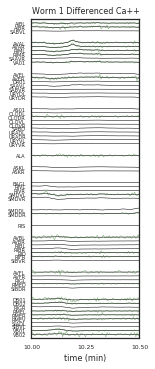

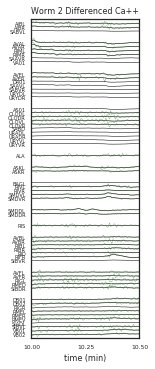

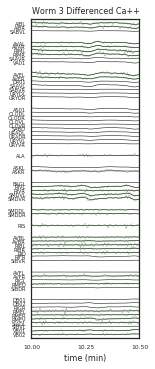

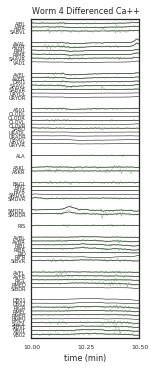

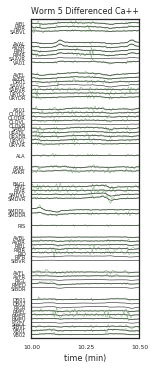

In [19]:
all_ys = np.vstack(ys)
all_ms = np.vstack(ms)
all_ys[~all_ms] = np.nan
scales = np.nanstd(all_ys, axis=0)

for i in range(N_worms):
    ysm = best_model.smooth(ys[i], mask=ms[i],
                            inputs=np.ones((ys[i].shape[0], 1)),
                            group=i)

    y = ys[i].copy()
    spc = 5

    n_start = 10 * 60 * 3
    n_frames = int(.5 * 60) * 3 + 1
    t = (n_start + np.arange(n_frames)) / 180.0

    fig = plt.figure(figsize=(2.15, 5))
    ax = create_axis_at_location(fig, 0.5, 0.4, 1.5, 4.43)
    offset = 0
    ticks = []
    for c in range(N_clusters):
        for n in neuron_perm:
            if neuron_clusters[n] != c:
                continue

            if ms[i][0, n]:
                plt.plot(t, -y[n_start:n_start + n_frames, n] / scales[n] + spc * offset, '-', color=colors[3],
                         lw=.5)
            else:
                # plt.plot(t, np.zeros_like(t) + spc * offset, ':', color='k', lw=.5)
                pass
            plt.plot(t, -ysm[n_start:n_start + n_frames, n] / scales[n] + spc * offset, '-', color='k', lw=.5)

            ticks.append(offset * spc)
            offset += 1

        # Add an extra space between clusters
        offset += 2

    # Remove last space
    offset -= 2

    plt.yticks(ticks, neuron_names[neuron_perm], fontsize=5)
    plt.ylim(offset * spc, -spc)
    plt.ylim(offset * spc, -spc)
    plt.xlim(t[0], t[-1])
    plt.xticks([t[0], t[n_frames//2], t[-1]], fontsize=6)
    plt.xlabel("time (min)", fontsize=8)

    plt.title("Worm {} Differenced Ca++".format(i + 1), fontsize=8)

    plt.savefig(os.path.join(fig_dir, "y_zoom_{}.pdf".format(i)))

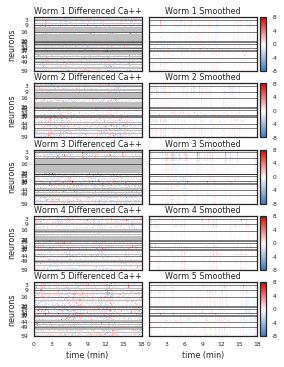

In [20]:
all_ys = np.vstack(ys)
all_ms = np.vstack(ms)
all_ys[~all_ms] = np.nan
scales = np.nanstd(all_ys, axis=0)
all_ys /= scales[None, :]
# ylim = 1.05 * np.nanmax(abs(all_ys))
ylim = 8
cticks = [-8, -4, 0, 4, 8]
cticklabels = ["-8", "-4", " 0", " 4", " 8"]

fig = plt.figure(figsize=(3.85, 5))

for i in range(N_worms):
    ax = create_axis_at_location(fig, 0.4, 5 - (i+1) * 0.92, 1.5, 0.75)

    # Plot the observed data
    y = ys[i].copy()
    y /= scales[None, :]
    y[~ms[i]] = np.nan

    cmap = gradient_cmap([colors[0], np.ones(3), colors[1]])
    cmap.set_bad(0.75 * np.ones(3))
    plt.imshow(y[:,neuron_perm].T, cmap=cmap, vmin=-ylim, vmax=ylim,
               aspect="auto", interpolation="nearest")

    # Plot cluster dividers
    for o in cluster_offsets[:-1]:
        plt.plot([0, 3240], [o + .5, o + .5], '-', lw=.5, color='k')

    plt.yticks(cluster_offsets, cluster_offsets+1, fontsize=6)
    plt.ylabel("neurons", fontsize=8)

    plt.xlim(0, 3240)
    if i == N_worms - 1:
        plt.xticks(np.arange(19, step=3) * 60 * 3, np.arange(19, step=3), fontsize=6)
        plt.xlabel("time (min)", fontsize=8)
    else:
        plt.xticks([])

    plt.title("Worm {} Differenced Ca++".format(i+1), y=.95, fontsize=8)

    # Plot the smoothed activity
    ax = create_axis_at_location(fig, 2.0, 5 - (i + 1) * 0.92, 1.5, 0.75)
    ysm = best_model.smooth(ys[i], mask=ms[i],
                            inputs=np.ones((ys[i].shape[0], 1)),
                            group=i)
    ysm /= scales[None, :]
    im = plt.imshow(ysm[:, neuron_perm].T, cmap=cmap, vmin=-ylim, vmax=ylim,
                    aspect="auto", interpolation="nearest")

    # Plot cluster dividers
    for o in cluster_offsets[:-1]:
        plt.plot([0, 3240], [o + .5, o + .5], '-', lw=.5, color='k')

    plt.yticks([])
    plt.xlim(0, 3240)
    if i == N_worms - 1:
        plt.xticks(np.arange(19, step=3) * 60 * 3, np.arange(19, step=3), fontsize=6)
        plt.xlabel("time (min)", fontsize=8)
    else:
        plt.xticks([])

    plt.title("Worm {} Smoothed".format(i + 1), y=.95, fontsize=8)

    # Make a colorbar
    cax = create_axis_at_location(fig, 3.55, 5 - (i + 1) * 0.92, 0.075, 0.75)
    cbar = plt.colorbar(im, cax=cax, ticks=cticks)
    cbar.ax.tick_params(labelsize=6)
    cbar.ax.set_yticklabels(cticklabels)

plt.savefig(os.path.join(fig_dir, "y_matrix.pdf"))


cluster  0
{0.07: 2, 0.08: 2, 0.09: 2, 0.1: 2, 0.11: 2, 0.12: 2, 0.13: 2, 0.14: 2.75, 0.15: 2.75, 0.16: 2, 0.17: 2, 0.18: 2, 0.19: 2, 0.2: 2.75, 0.21: 2, 0.22: 2, 0.23: 2, 0.24: 2, 0.25: 2, 0.26: 2, 0.27: 2, 0.28: 2, 0.29: 2, 0.3: 2, 0.31: 2, 0.32: 2, 0.33: 2, 0.34: 2, 0.35: 2, 0.36: 2, 0.37: 2, 0.38: 2, 0.39: 2, 0.4: 2, 0.42: 2, 0.43: 2, 0.44: 2, 0.45: 2, 0.46: 2, 0.47: 2, 0.5: 2, 0.51: 2, 0.52: 2, 0.53: 2, 0.54: 2, 0.55: 2, 0.57: 2, 0.58: 2, 0.59: 2, 0.6: 2, 0.61: 2, 0.62: 2, 0.64: 2, 0.65: 2, 0.66: 2, 0.67: 2, 0.68: 2, 0.69: 2, 0.71: 2, 0.72: 2, 0.73: 2, 0.74: 2, 0.77: 2, 0.79: 2, 0.8: 2, 0.81: 2, 0.82: 2, 0.83: 2}
cluster  1
{0.07: 2, 0.08: 2, 0.09: 2, 0.1: 2, 0.11: 2, 0.12: 2, 0.13: 4.25, 0.14: 2, 0.15: 2.75, 0.16: 2.75, 0.17: 2, 0.18: 2, 0.19: 2, 0.2: 2, 0.21: 2, 0.22: 2, 0.23: 2.75, 0.24: 2, 0.25: 2, 0.26: 2, 0.27: 2, 0.28: 2, 0.29: 2, 0.3: 2, 0.31: 2, 0.32: 2, 0.33: 2, 0.34: 2, 0.35: 2, 0.36: 2, 0.37: 2, 0.38: 2, 0.39: 2, 0.4: 2, 0.42: 2, 0.43: 2, 0.44: 2, 0.45: 2, 0.46: 2, 0.4

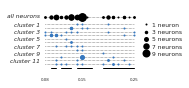

In [21]:
import pandas
locs = pandas.read_csv("wormatlas_locations.csv").values
l_values = np.unique(locs[:,1])

# for lv in l_values:
#     print("{} - {}".format(lv, np.sum(locs[:,1] == lv)))

fig = plt.figure(figsize=(2.75, 1.0))
# ax = fig.add_subplot(111)
ax = create_axis_at_location(fig, 0.3, 0.05, 2.1, .9)
spc = 1

sizes = dict([(lv, 2) for lv in l_values])
ax.plot([0.08, 0.25], np.zeros(2), ':k', lw=0.5)
for name in neuron_names:
    i2 = np.where(locs[:, 0] == name)[0][0]
    l = locs[i2, 1]
    plt.plot(l, 0, 'ko', markersize=sizes[l], alpha=1.0)
    sizes[l] += .75
ax.text(0.07, 0, "all neurons", fontsize=6, style="italic", horizontalalignment="right")

for cluster in range(N_clusters):
    sizes = dict([(lv, 2) for lv in l_values])
    yoff = spc + spc * (cluster+1)
    ax.plot([0.08, 0.25], yoff * np.ones(2), ':k', lw=0.5)
    for i1 in np.where(neuron_clusters == cluster)[0]:
        i2 = np.where(locs[:,0] == neuron_names[i1])[0][0]
        l = locs[i2, 1]
        plt.plot(l, yoff, 'o', color=colors[0], markersize=sizes[l], alpha=1.0)
        sizes[l] += .75

    if cluster % 2 == 0:
        ax.text(0.07, yoff+.5, "cluster {}".format(cluster+1), fontsize=6, style="italic", horizontalalignment="right")


    print("cluster ", cluster)
    print(sizes)
# Make a legend
ax.plot(.273, 2, 'ko', markersize=2)
ax.text(.285, 2.5, "1 neuron", fontsize=6)
ax.plot(.273, 4, 'ko', markersize=3.5)
ax.text(.285, 4.5, "3 neurons", fontsize=6)
ax.plot(.273, 6, 'ko', markersize=5)
ax.text(.285, 6.5, "5 neurons", fontsize=6)
ax.plot(.273, 8, 'ko', markersize=6.5)
ax.text(.285, 8.5, "7 neurons", fontsize=6)
ax.plot(.273, 10, 'ko', markersize=8)
ax.text(.285, 10.5, "9 neurons", fontsize=6)

ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.set_xlim([0.01, 0.30])
ax.set_yticks([])
ax.set_ylim(spc * (N_clusters + 3), -3 * spc)
plt.xticks([0.08, 0.15, 0.25], fontsize=4)

# Draw lines for the head ganglia
# Reference http://www.wormatlas.org/ver1/MoW_built0.92/art/intro_figs/figure2.jpg
# Anterior ganglion is from OLGDL (0.09) to BAGL (0.1)
# Dorsal is from RID (0.11) to ASKL (0.13)
# Ventral ganglion is from ASKL (.13) to SABVL (.2)
# RVG is from VB02 (0.19) to VD02 (0.26)
# ax.plot(0.095, spc * (N_clusters + 2), 'k^', markersize=3)
ax.plot([.09, .1], spc * (N_clusters + 2) * np.ones(2), '-k', lw=1)
# ax.plot(0.1, spc * (N_clusters + 2), 'k^', markersize=3)
ax.plot([.11, .13], spc * (N_clusters + 2) * np.ones(2), '-k', lw=1)
# ax.plot(0.15, spc * (N_clusters + 2), 'k^', markersize=3)
ax.plot([.14, .17], spc * (N_clusters + 2) * np.ones(2), '-k', lw=1)
# ax.plot(.225, spc * (N_clusters + 2), 'k^', markersize=3)
ax.plot([.19, .25], (spc * (N_clusters + 2)) * np.ones(2), '-k', lw=1)


# ax.set_xlabel("location along head-tail axis", fontsize=6)
plt.savefig(os.path.join(fig_dir, "cluster_locs.pdf"))


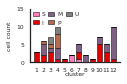

In [22]:
# Break down cells into 5 types: sensory, inter, motor, poly, unknown
import pandas
all_types = pandas.read_csv("wormatlas_celltypes.csv", header=0,
                         dtype=dict(Name=str, S=int, I=int, M=int, P=int, U=int))

N_atlas = all_types.shape[0]

type_names = ["S", "I", "M", "P", "U"]
type_colors = [colors[7], colors[1], colors[4], colors[6], "gray"]

fig = plt.figure(figsize=(1.6, 1.0))
ax = fig.add_subplot(111)

for cluster in range(N_clusters):
    inds = np.where(neuron_clusters == cluster)[0]
    cluster_types = np.zeros(5)
    for j in inds:
        jmatch = np.where(all_types["Name"].values == neuron_names[j])[0]
        assert len(jmatch) == 1
        for i, key in enumerate(type_names):
            cluster_types[i] += all_types[key].values[jmatch[0]]
            
    assert cluster_types.sum() == len(inds)
    bottom = np.concatenate(([0], np.cumsum(cluster_types)[:-1]))

    for i in range(5):
        ax.bar(cluster, cluster_types[i], width=0.8, bottom=bottom[i],
               color=type_colors[i],
               edgecolor='k', linewidth=.5,
               label=type_names[i] if cluster == 0 else None
               )

plt.xticks(np.arange(N_clusters), np.arange(N_clusters) + 1)
plt.xlabel("cluster", fontsize=6, labelpad=-1)
plt.ylabel("cell count", fontsize=6)
plt.ylim(0, 15)

ax.tick_params(labelsize=6)
# ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.spines["bottom"].set_visible(False)
ax.legend(loc="upper left", ncol=3, fontsize=6, borderpad=0, handlelength=1, labelspacing=.5, columnspacing=.5, handletextpad=.5)

plt.tight_layout(pad=.1)

plt.savefig(os.path.join(fig_dir, "cluster_types.pdf"))

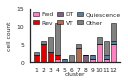

In [23]:
import pandas
all_funcs = pandas.read_csv("neuron_functions.csv", header=0,
                         dtype=dict(Name=str, Fwd=int, Rev=int, DT=int, VT=int, Other=int, Quiescence=int, References=str, Notes=str))

func_names = ["Fwd", "Rev", "DT", "VT", "Quiescence", "Other",]
func_colors = [colors[7], colors[1], colors[4], colors[6], colors[11], "gray"]

fig = plt.figure(figsize=(1.6, 1.0))
ax = fig.add_subplot(111)

for cluster in range(N_clusters):
    inds = np.where(neuron_clusters == cluster)[0]
    cluster_funcs = np.zeros(6)
    for j in inds:
        jmatch = np.where(all_funcs["Name"].values == neuron_names[j])[0]
        assert len(jmatch) == 1
        for i, key in enumerate(func_names):
            cluster_funcs[i] += all_funcs[key].values[jmatch[0]]
            
#     assert cluster_funcs.sum() == len(inds)
    bottom = np.concatenate(([0], np.cumsum(cluster_funcs)[:-1]))

    for i in range(6):
        ax.bar(cluster, cluster_funcs[i], width=0.8, bottom=bottom[i],
               color=func_colors[i],
               edgecolor='k', linewidth=.5,
               label=func_names[i] if cluster == 0 else None
               )

plt.xticks(np.arange(N_clusters), np.arange(N_clusters) + 1)
plt.xlabel("cluster", fontsize=6, labelpad=-1)
plt.ylabel("cell count", fontsize=6)
plt.ylim(0, 15)

ax.tick_params(labelsize=6)
# ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.spines["bottom"].set_visible(False)
ax.legend(loc="upper left", ncol=3, fontsize=6, borderpad=0, handlelength=1, labelspacing=.5, columnspacing=.5, handletextpad=.5)

plt.tight_layout(pad=.1)

plt.savefig(os.path.join(fig_dir, "cluster_functions.pdf"))